In [37]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [38]:
sales_data = pd.read_csv("Case2_Sales data.csv")
sales_data.head(5)

,DATE,Mapped_GCK,Sales_EUR
0,01.10.2018,#1,0
1,02.10.2018,#1,0
2,03.10.2018,#1,0
3,04.10.2018,#1,0
4,05.10.2018,#1,0


In [39]:
market_data = pd.read_excel("Case2_Market data.xlsx", header=None)
market_data.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,NaN,China,China,France,France,Germany,Germany,Italy,Italy,Japan,Japan,Switzerland,Switzerland,United Kingdom,United Kingdom,United States,United States,Europe,Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Producer Prices,Producer Prices,Producer Prices,Producer Prices,Producer Prices,Producer Prices,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index
1,Index 2010=100 (if not otherwise noted),Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,World: Price of Base Metals,World: Price of Energy,World: Price of Metals & Minerals,World: Price of Natural gas index,"World: Price of Crude oil, average",World: Price of Copper,United States: EUR in LCU,United States: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment,China: Electrical equipment,United States: Machinery and equipment n.e.c.,World: Machinery and equipment n.e.c.,Switzerland: Machinery and equipment n.e.c.,United Kingdom: Machinery and equipment n.e.c.,Italy: Machinery and equipment n.e.c.,Japan: Machinery and equipment n.e.c.,France: Machinery and equipment n.e.c.,Germany: Machinery and equipment n.e.c.,United States: Electrical equipment,World: Electrical equipment,Switzerland: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,Japan: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment
2,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_PRO840,MAB_ELE_SHP840,MAB_ELE_PRO1100,MAB_ELE_SHP1100,RohiBASEMET1000_org,RohiENERGY1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCRUDE_PETRO1000_org,RohCOPPER1000_org,WKLWEUR840_org,PRI27840_org,PRI27826_org,PRI27380_org,PRI27250_org,PRI27276_org,PRI27156_org,PRO28840_org,PRO281000_org,PRO28756_org,PRO28826_org,PRO28380_org,PRO28392_org,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
3,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,110.495272,91.221862,89.987275,111.353812,73.601265,107.6014,79.24023,97.122911,80.09853,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.1,106.191977,116.790276,110.890034,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
4,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.62748,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,1

In [40]:
# Count occurrences of 0 and non-zero Sales
zero_count = (sales_data["Sales_EUR"] == 0).sum()
non_zero_count = (sales_data["Sales_EUR"] != 0).sum()

# Print the counts
print(f"Zero Sales Count: {zero_count}")
print(f"Non-Zero Sales Count: {non_zero_count}")

Zero Sales Count: 7135
Non-Zero Sales Count: 2667


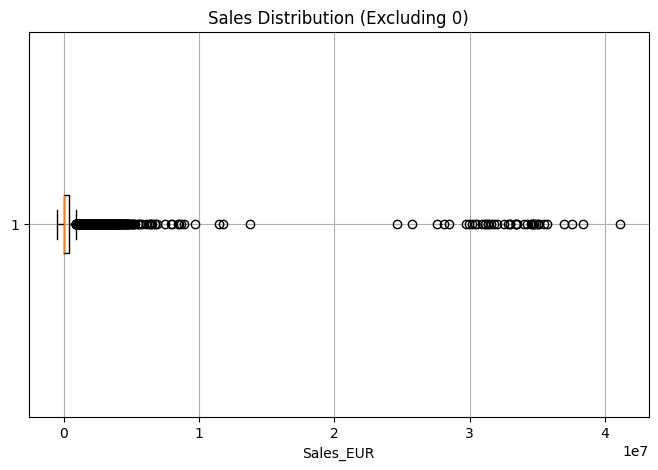

In [41]:
# Exclude 0 values
filtered_sales = sales_data[sales_data["Sales_EUR"] != 0]["Sales_EUR"]

# Boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(filtered_sales, vert=False)
plt.title("Sales Distribution (Excluding 0)")
plt.xlabel("Sales_EUR")
plt.grid(True)
plt.show()

In [42]:
# Convert DATE column to datetime format
sales_data["DATE"] = pd.to_datetime(sales_data["DATE"], format="%d.%m.%Y")

# Check for duplicate dates
duplicate_dates = sales_data["DATE"].duplicated().sum()

# Count occurrences of each unique date
date_counts = sales_data["DATE"].value_counts().sort_index()

# Display results
print(f"Number of duplicate dates: {duplicate_dates}")
print("\nFirst 10 occurrences of dates:")
print(date_counts.head(10))

Number of duplicate dates: 8586

First 10 occurrences of dates:
DATE
2018-10-01     9
2018-10-02    10
2018-10-03     1
2018-10-04     6
2018-10-05     8
2018-10-06     1
2018-10-08     7
2018-10-09     9
2018-10-10    10
2018-10-11     8
Name: count, dtype: int64


In [43]:
# Merge first row with current column names
market_data.columns = market_data.iloc[0].astype(str) + " - " + market_data.iloc[1].astype(str)

# Drop the first two rows since they are now merged into headers
market_data = market_data.iloc[2:].reset_index(drop=True)

# Display the first few rows to verify the fix
market_data.head()

,nan - Index 2010=100 (if not otherwise noted),China - Production Index Machinery & Electricals,China - Shipments Index Machinery & Electricals,France - Production Index Machinery & Electricals,France - Shipments Index Machinery & Electricals,Germany - Production Index Machinery & Electricals,Germany - Shipments Index Machinery & Electricals,Italy - Production Index Machinery & Electricals,Italy - Shipments Index Machinery & Electricals,Japan - Production Index Machinery & Electricals,Japan - Shipments Index Machinery & Electricals,Switzerland - Production Index Machinery & Electricals,Switzerland - Shipments Index Machinery & Electricals,United Kingdom - Production Index Machinery & Electricals,United Kingdom - Shipments Index Machinery & Electricals,United States - Production Index Machinery & Electricals,United States - Shipments Index Machinery & Electricals,Europe - Production Index Machinery & Electricals,Europe - Shipments Index Machinery & Electricals,nan - World: Price of Base Metals,nan - World: Price of Energy,nan - World: Price of Metals & Minerals,nan - World: Price of Natural gas index,"nan - World: Price of Crude oil, average",nan - World: Price of Copper,nan - United States: EUR in LCU,Producer Prices - United States: Electrical equipment,Producer Prices - United Kingdom: Electrical equipment,Producer Prices - Italy: Electrical equipment,Producer Prices - France: Electrical equipment,Producer Prices - Germany: Electrical equipment,Producer Prices - China: Electrical equipment,production index - United States: Machinery and equipment n.e.c.,production index - World: Machinery and equipment n.e.c.,production index - Switzerland: Machinery and equipment n.e.c.,production index - United Kingdom: Machinery and equipment n.e.c.,production index - Italy: Machinery and equipment n.e.c.,production index - Japan: Machinery and equipment n.e.c.,production index - France: Machinery and equipment n.e.c.,production index - Germany: Machinery and equipment n.e.c.,production index - United States: Electrical equipment,production index - World: Electrical equipment,production index - Switzerland: Electrical equipment,production index - United Kingdom: Electrical equipment,production index - Italy: Electrical equipment,production index - Japan: Electrical equipment,production index - France: Electrical equipment,production index - Germany: Electrical equipment
0,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_PRO840,MAB_ELE_SHP840,MAB_ELE_PRO1100,MAB_ELE_SHP1100,RohiBASEMET1000_org,RohiENERGY1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCRUDE_PETRO1000_org,RohCOPPER1000_org,WKLWEUR840_org,PRI27840_org,PRI27826_org,PRI27380_org,PRI27250_org,PRI27276_org,PRI27156_org,PRO28840_org,PRO281000_org,PRO28756_org,PRO28826_org,PRO28380_org,PRO28392_org,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
1,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,110.495272,91.221862,89.987275,111.353812,73.601265,107.6014,79.24023,97.122911,80.09853,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.1,106.191977,116.790276,110.890034,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
2,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.62748,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,119.220779,NaN,76.690307,138.30955,152.8802

In [47]:
# Get unique values from the middle column (Mapped_GCK)
unique_values = sales_data["Mapped_GCK"].unique()

# Count the number of unique values
num_unique_values = len(unique_values)

# Display results
print(f"Number of unique values in Mapped_GCK: {num_unique_values}")
print("Unique values:")
print(unique_values)

Number of unique values in Mapped_GCK: 14
Unique values:
['#1' '#11' '#6' '#8' '#12' '#16' '#4' '#5' '#3' '#9' '#14' '#13' '#20'
 '#36']


In [48]:
# Count occurrences of each unique value in Mapped_GCK
mapped_gck_counts = sales_data["Mapped_GCK"].value_counts()

# Display the counts
print("Count of each unique value in Mapped_GCK:")
print(mapped_gck_counts)

# Get the total number of rows in the dataset
total_rows = len(sales_data)

# Display the total number of rows
print(f"\nTotal number of rows in the dataset: {total_rows}")


Count of each unique value in Mapped_GCK:
Mapped_GCK
#1     1179
#3     1017
#5      959
#8      944
#4      877
#12     803
#6      794
#16     765
#11     732
#13     441
#36     434
#9      333
#20     293
#14     231
Name: count, dtype: int64

Total number of rows in the dataset: 9802


In [49]:
# Count duplicate DATEs for each unique Mapped_GCK
duplicates_by_gck = sales_data.groupby("Mapped_GCK")["DATE"].apply(lambda x: x.duplicated().sum())

# Display results
print("Duplicate DATEs per Mapped_GCK:")
print(duplicates_by_gck)

Duplicate DATEs per Mapped_GCK:
Mapped_GCK
#1     0
#11    0
#12    0
#13    0
#14    0
#16    0
#20    0
#3     0
#36    0
#4     0
#5     0
#6     0
#8     0
#9     0
Name: DATE, dtype: int64
